### Get data

In [78]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
# from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

In [79]:
df = pd.read_csv('brooklyn_clean_final.csv', index_col=0)
print(df.columns)

X = df.drop(['SALE_PRICE'], 1)
y = df[['SALE_PRICE']]
y_classified = y.copy(True)
row_num = X.shape[0]

#print(X['11228'])  
#print(X.head(100))

def add_zipcode(zipcodes):
    for zipcode in zipcodes:
        zeros = np.zeros(row_num+1)
        s = pd.Series(zeros)
        key = str(zipcode)
        X[key] = s
        for pos in range(0,row_num):
            if X.iloc[pos]['ZIPCODE'] == zipcode:
                X.set_value(pos+1, key, 1)
                
def add_taxclass(taxclass):
    for tax in taxclass:
        zeros = np.zeros(row_num+1)
        s = pd.Series(zeros)
        key = str(tax)
        X["TAX:"+key] = s
        for pos in range(0,row_num):
            if X.iloc[pos]['TAX_CLASS'] == tax:
                X.set_value(pos+1, "TAX:"+key, 1)
                

def add_buildingclass(buildingclass):
    for building in buildingclass:
        zeros = np.zeros(row_num+1)
        s = pd.Series(zeros)
        key = str(building)
        X["building:"+key] = s
        for pos in range(0,row_num):
            if X.iloc[pos]['TAX_CLASS'] == building:
                X.set_value(pos+1, "building:"+key, 1)

zipcodes = [11239, 11236,11208,11207,11234,11203,11212,11224,11210,
            11229,11233,11228,11204,11214,11221,11209,11235,11213,11223,11220,
            11219,11218,11230,11226,11232,11237,11216,11225,11231,11215,11222,11217,11238,11206,11205,11211,11249,11201]
taxclass = [1,2,4]
buildingclass = np.arange(1, 219)


add_zipcode(zipcodes)
add_taxclass(taxclass)
add_buildingclass(buildingclass)


Index(['ZIPCODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'GROSS_SQUARE_FEET',
       'AGE', 'TAX_CLASS', 'BUILDING_CLASS', 'SALE_PRICE'],
      dtype='object')


In [80]:
X = X.drop(['ZIPCODE', "TAX_CLASS"], 1)
print(X.head(1))

   RESIDENTIAL_UNITS  COMMERCIAL_UNITS  GROSS_SQUARE_FEET  AGE  \
1                  1                 0               1660   87   

   BUILDING_CLASS  11239  11236  11208  11207  11234  11203  11212  11224  \
1               6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   11210  11229  11233  11228  11204  11214  11221  11209  11235  11213  \
1    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   

   11223  11220  11219  11218  11230  11226  11232  11237  11216  11225  \
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   11231  11215  11222  11217  11238  11206  11205  11211  11249  11201  \
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   TAX:1  TAX:2  TAX:4  building:1  building:2  building:3  building:4  \
1    1.0    0.0    0.0         1.0         0.0         0.0         0.0   

   building:5  building:6  building:7  building:8  building:9  building:10  \
1         0.0         0.0       

change the price value into 1 or 0, depending on whether it satisfies the given condition.

In [81]:
# Set the upper bound of the price
def classify_y(price):
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] >= price:
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',0)
            
# Set the lower bound of the price            
def classify_y_down(price):
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] <= price:
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',0)
            
            
def classify_y_range(low, high):
    for pos in range(0,8497):
        if y.iloc[pos]['SALE_PRICE'] <= high & y.iloc[pos]['SALE_PRICE'] >= low:
            y_classified.set_value(pos+1, 'SALE_PRICE', 1)
        else: 
            y_classified.set_value(pos+1, 'SALE_PRICE',0)
            

            

In [91]:
classify_y_range(250000, 500000)

Use Lasso Regularization to predict whether the price falls into certain price category.

8.1113083079e-05


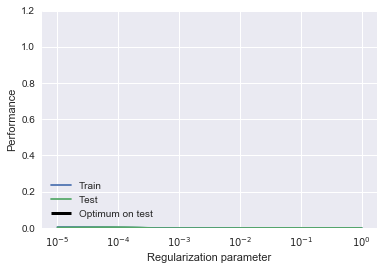

In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_classified, test_size=0.1, random_state=42)

alphas = np.logspace(-5,0,100)
scores = []   

#best_alpha = alphas[best_alpha_index]
train_errors=[]
test_errors=[]

for alpha in alphas:
    regr = Lasso(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train, y_train))
    test_errors.append(regr.score(X_test,y_test))

best_alpha_index = np.argmax(test_errors)
alpha_optim= alphas[best_alpha_index]
print(alpha_optim)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

Use Ridge Regularization to predict whether the price satisfies certain condition.

1.0


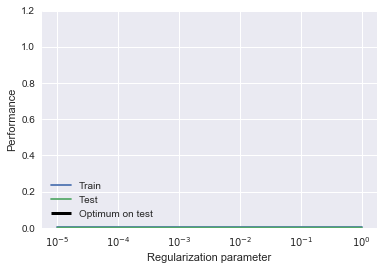

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_classified, test_size=0.1, random_state=42)

alphas = np.logspace(-5,0,100)
scores = []   

#best_alpha = alphas[best_alpha_index]
train_errors=[]
test_errors=[]

for alpha in alphas:
    regr = Ridge(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train, y_train))
    test_errors.append(regr.score(X_test,y_test))

best_alpha_index = np.argmax(test_errors)
alpha_optim= alphas[best_alpha_index]
print(alpha_optim)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

Area under the ROC curve : 0.478632
Area under the ROC curve : 0.496247
Area under the ROC curve : 0.495590
Area under the ROC curve : 0.503506
best_depth is 4
Area under the ROC curve : 0.503506


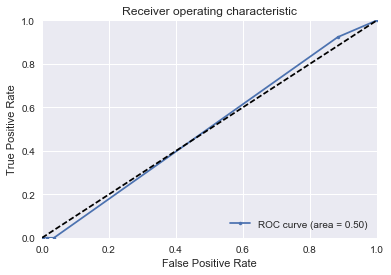

In [94]:
from sklearn.tree import DecisionTreeClassifier
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(1)
    # Construct training and testing set.
    X, y = shuffle(X, y_classified, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
scores = []
depths = np.arange(1, 5)
for depth in depths:
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,criterion='entropy', max_depth=depth)
    scores.append(roc_auc)
# plt.plot(alphas,scores)

best_depth = depths[np.argmax(scores)]
print("best_depth is", best_depth)
# Generate ROC  for LR with l1 penalty and C=alpha_best
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,criterion='entropy', max_depth=best_depth)
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)



Area under the ROC curve : 0.478632
Area under the ROC curve : 0.496247
Area under the ROC curve : 0.495590
Area under the ROC curve : 0.503506
best_depth is 4
Area under the ROC curve : 0.503506


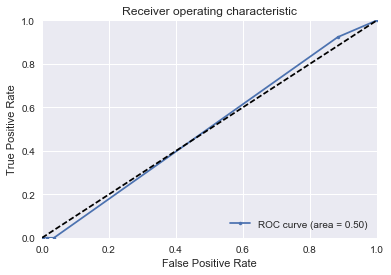

In [110]:
classify_y_range(400000, 500000)

scores = []
depths = np.arange(1, 5)
for depth in depths:
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,criterion='entropy', max_depth=depth)
    scores.append(roc_auc)
# plt.plot(alphas,scores)

best_depth = depths[np.argmax(scores)]
print("best_depth is", best_depth)
# Generate ROC  for LR with l1 penalty and C=alpha_best
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,criterion='entropy', max_depth=best_depth)
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


In [96]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [97]:
from __future__ import print_function
from sklearn.tree import DecisionTreeRegressor
import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt=DecisionTreeRegressor(max_depth=5)

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X, y)

visualize_tree(regr_1, feature_names=['x'])

In [98]:
row_num = X.shape[0]
print(row_num)

8497
